# The Knee Algorithm

In this notebook we implement a simple version of the 'knee method' stopping criterion algorithm. See [Cormack & Grossman (2016)](https://doi.org/10.1145/2911451.2911510) for the original algorithm. Cormack & Grossman (2016) also provide details on how to handle cases with a low total of relevant papers (*R*) and a low ratio of relevant papers to the total number of papers (*R*/|*C*|).

We will use a dataset that can be exported from the [ASReview](https://asreview.nl/) tool, which helps users to automate reviews with the help of active learning. Note that the dataset is the result of a completed systematic review screening process, but the knee algorithm is intended to be applied during the screening process to provide a stopping criterion.

In [1]:
import pandas as pd

df = pd.read_csv('ASReviewLABprogressRecall.2.csv')
df.head()

,category,Relevant by ASReview LAB,Random relevant
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,1
4,5,1,1


We now proceed to the actual knee algorithm. For each evaluation point *s*, we look back to (nearly) all earlier evaluation points *i* to see if the slope between 1 and *i* is more than ρ times as high than the slope between *i* and *s*, for a particular cutoff value ρ. There are faster implementations of this algorithm, as also mentioned in Cormack & Grossman (2016). The below cell defines a function that takes the minimum number of relevant papers reached *k* and the slope ratio cutoff value ρ as inputs, and outputs the relevant knee algorithm results.

In [2]:
def calculate_knee_values(k, rho, df):

    # Variables to store stopping values
    stop_i = -1
    stop_s = -1
    stop_relevant = -1
    slope_stop = -1
    
    for rank_s, relevant in zip(df['category'], df['Relevant by ASReview LAB']):
        
        # If knee found, break
        if stop_s > 0:
            break
        
        # If number relevant less than k, do not even need to consider stopping
        if relevant < k:
            continue
        
        # Index (start=0) is one lower than rank (start=1)
        index_s = rank_s - 1
        
        # Loop over all i and compare slopes
        for rank_i in range(1, rank_s):
            
            # Calculate slope until i
            index_i = rank_i - 1
            num_relevant_i = df['Relevant by ASReview LAB'][index_i]
            
            slope_i = num_relevant_i / rank_i
            
            # If slope until i is zero, cannot exceed cutoff
            if slope_i == 0:
                continue
            
            num_relevant_s = df['Relevant by ASReview LAB'][index_s]
            
            # Calculate slope of s
            # Add 1 to numerator to avoid edge cases with i very close to s
            slope_s = (1 + num_relevant_s - num_relevant_i) / (rank_s - rank_i)
            
            # Calculate slope ratio
            slope_ratio = slope_i / slope_s
            
            # Check if slope_ratio greater than cutoff
            if slope_ratio > rho:
                stop_i = rank_i
                stop_s = rank_s
                stop_relevant = num_relevant_s
                slope_stop = slope_ratio
                break
                
    return stop_i, stop_s, stop_relevant, slope_stop

First, let's calculate the relevant results using the default values suggested by Cormack & Grossman (2016). Later, we will see what the effect is of changing the ρ value.

In [3]:
k = 10
rho = 6

i, s, num_relevant, slope_ratio = calculate_knee_values(k, rho, df)

In [4]:
print('We stop at s=' + str(s) + ' since the slope from 0 to i='
      + str(i) + ' is ' + str(round(slope_ratio, 2)) + ' times higher '
     + 'than the intermediate slope between i and s.')

We stop at s=432 since the slope from 0 to i=421 is 6.11 times higher than the intermediate slope between i and s.


In this specific case, we can calculate the recall achieved using this algorithm, since we know *R*. Remember that *R* is normally not known while performing a systematic review. When using automated approaches, you generally never get to know the true value of *R*.

In [5]:
R = df['Random relevant'].iat[-1] # number of relevant documents, generally unknown

In [6]:
print('At the stopping point we have found ' + str(num_relevant)
     + ' relevant papers. This corresponds to a recall of '
     + str(round(num_relevant/R, 2)*100) + '%.')

At the stopping point we have found 234 relevant papers. This corresponds to a recall of 84.0%.


We could additionally plot an overview of the results, although this is mostly relevant if the scales allow us to clearly see the difference between *i* and *s*.

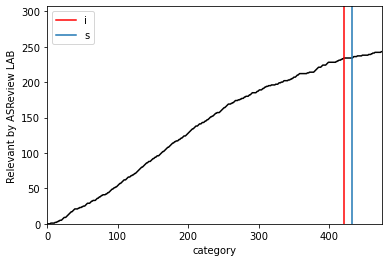

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(data=df, x = 'category', y = 'Relevant by ASReview LAB', color='k')
plt.axvline(i, label='i', color='r')
plt.axvline(s, label='s')

plt.legend()
plt.xlim([0, s * 1.1])
plt.ylim([0, R * 1.1])

plt.show()

Given our function, we can additionally analyse the tradeoff between number of evaluated papers and recall for various values of ρ.

In [8]:
import numpy as np
from tqdm.notebook import tqdm

k = 10

# WARNING: setting 'num' high (e.g., >500) will cause code to take very long
rho_values = np.linspace(3, 10, num = 100)

s_values = []
num_rel_values = []

for rho_value in tqdm(rho_values):
    
    i, s, n, r = calculate_knee_values(k, rho_value, df)
    
    s_values.append(s)
    num_rel_values.append(n)

  0%|          | 0/100 [00:00<?, ?it/s]

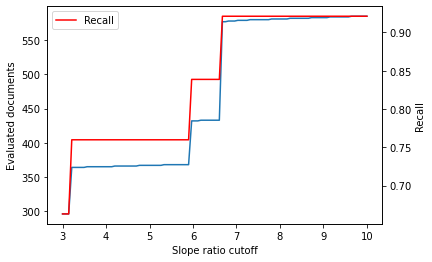

In [9]:
ax = sns.lineplot(x = rho_values, y = s_values)
ax2 = plt.twinx()
sns.lineplot(x = rho_values, y = num_rel_values/R, label = 'Recall', color='r', ax=ax2)

ax.set(xlabel='Slope ratio cutoff', ylabel='Evaluated documents')
ax2.set(ylabel='Recall')

plt.show()